# Imports

In [1]:
import pandas as pd
from nltk.tokenize                   import RegexpTokenizer
from bs4                             import BeautifulSoup  
from nltk.corpus                     import stopwords
from sklearn.linear_model            import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline                import Pipeline,FeatureUnion
from sklearn.model_selection         import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics                 import confusion_matrix,classification_report
import warnings

warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('../datasets/clean-tweets/clean_tweets.csv').drop(columns='Unnamed: 0')

# PreProcessing

In [3]:
df.isnull().sum()

username        0
text            0
label           0
dates           0
clean_text    230
target          0
lat             0
long            0
zip             0
dtype: int64

In [4]:
df.dropna(how='any',inplace=True)

In [5]:
df.isnull().sum()

username      0
text          0
label         0
dates         0
clean_text    0
target        0
lat           0
long          0
zip           0
dtype: int64

In [6]:
df.shape

(1261, 9)

In [7]:
X = df['clean_text']
y=df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3, stratify = y)

In [8]:
#Keep a vectorized DF for the records
cvec = CountVectorizer(max_df= 0.9,min_df=0.0012,ngram_range=(1,1))
cvec.fit(X_train)
DF = cvec.transform(X_train)
DF = pd.DataFrame(DF.toarray(),
                          columns=cvec.get_feature_names())

In [9]:
DF.shape

(882, 1185)

In [10]:
DF.to_csv('../datasets/countvec_words.csv')

# Model Set Up

In [11]:
# Define Pipeline
pipe = Pipeline(steps = [('vectorizer', CountVectorizer()),     # first tuple is for first step: vectorizer
                         ('model', LogisticRegression())        # second tuple is for second step: model
                        ])    

# Construct Grid Parameters
hyperparams = {'vectorizer__ngram_range': [(1,1), (2,2), (1,2)],
               'vectorizer__max_df': [0.9, 0.8, 1],
               'vectorizer__min_df':[0.0012],

               'model__penalty': ['l1', 'l2'],
               'model__C': [0.1, 1, 3, 10],
               'model__max_iter':[50,100,150]
            
              }

 # Perform Grid Search
gs = GridSearchCV(pipe, # pipeline object replaces what we usually had as empty model class
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')
results = gs.fit(X_train, y_train)

# Get best params
results.best_estimator_

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.9,
                                 max_features=None, min_df=0.0012,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('model',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=50,
                                    multi_class='warn', n_jobs=None,
              

In [12]:
vectorizer_params = results.best_estimator_.steps[0][1].get_params()
model_params = results.best_estimator_.steps[1][1].get_params()

# Get score
train_score = results.best_score_
print('Best TRAIN accuracy: {:.4f}'.format(train_score))
test_score = results.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))
results.best_params_

Best TRAIN accuracy: 0.8458
Best TEST set accuracy: 0.8391


{'model__C': 0.1,
 'model__max_iter': 50,
 'model__penalty': 'l1',
 'vectorizer__max_df': 0.9,
 'vectorizer__min_df': 0.0012,
 'vectorizer__ngram_range': (1, 1)}

In [13]:
pipe = Pipeline(steps = [('cv', CountVectorizer(max_df= 0.9,min_df=0.001,ngram_range=(1,1))),
                         ('model', LogisticRegression(C=0.1,max_iter=50,penalty='l1')),     
                        ])    

# Model Evaluation

In [14]:
#Get predictions and probabilities
results = pipe.fit(X_train, y_train);
pred=pipe.predict(X_test)
pred_proba=pipe.predict_proba(X_test)

In [15]:
#Confusion Matrix
cm=confusion_matrix(y_test, pred)

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt=".1f", cmap='YlOrBr', cbar=False); 
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Power Outage', 'Power Outage']); ax.yaxis.set_ticklabels(['No Power Outage', 'Power Outage']);

In [17]:
#Classification Report
from sklearn.metrics import classification_report
thresh = .7
print(classification_report(y_test, pred_proba[:, 1]>thresh))

              precision    recall  f1-score   support

           0       0.69      0.92      0.79       231
           1       0.74      0.34      0.47       148

    accuracy                           0.70       379
   macro avg       0.71      0.63      0.63       379
weighted avg       0.71      0.70      0.66       379



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.876


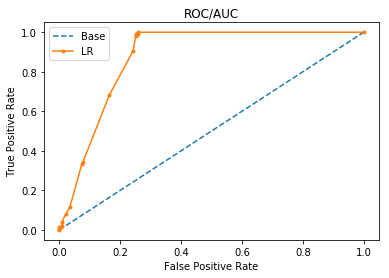

In [18]:
#ROC Curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ns_probs = [0 for _ in range(len(y_test))]

pipe_probs = pipe.predict_proba(X_test)
pipe_probs = pipe_probs[:, 1]
ns_auc = roc_auc_score(y_test, ns_probs)
pipe_auc = roc_auc_score(y_test, pipe_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (pipe_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pipe_fpr, pipe_tpr, _ = roc_curve(y_test, pipe_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Base')
plt.plot(pipe_fpr, pipe_tpr, marker='.', label='LR')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()
plt.title('ROC/AUC')

# show the plot
plt.show()

In [19]:
#Saving predictions
pred_train=pd.DataFrame(pipe.predict(X_train))
pred_train['origin']='train'
pred_train['index']=X_train.index
pred_test=pd.DataFrame(pipe.predict(X_test))
pred_test['origin']='test'
pred_test['index']=X_test.index

In [20]:
pred_test.to_csv('../datasets/preds_index.csv')

In [21]:
all_preds=pd.concat([pred_train,pred_test], axis=0,ignore_index=True)

In [22]:
all_preds.rename(columns={0:'preds','origin':'origin'},inplace=True)

In [23]:
df.reset_index(inplace=True)

In [24]:
df=pd.concat([df,all_preds],axis=1, )

In [25]:
df.to_csv('../datasets/tweets_and_preds.csv')